
# 📩 Day 11 — SMS Spam Detector (NLP)

**Goal:** Build a text classifier that detects **spam** vs **ham** SMS using TF‑IDF features and strong linear models (LogReg / Linear SVM / Naive Bayes).  
We’ll do: EDA → Cleaning → Vectorization → Modeling → Evaluation → Error Analysis → Export + Inference.

> Works on **Kaggle** (attach a dataset) or **local** (upload a CSV).


## 🔧 1) Setup

In [1]:

# If running locally, uncomment to install:
# !pip install scikit-learn pandas numpy matplotlib seaborn joblib

import os, re, string, sys, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from joblib import dump, load

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (6,4)



## 📥 2) Load Dataset (Kaggle or Local)

Supported Kaggle datasets (attach one via **Add data**):
- `sms-spam-collection-dataset`
- `uciml/sms-spam-collection-dataset`
- Any CSV with columns like `['v1','v2']` or `['Category','Message']` or `['label','text']`


In [6]:
# If needed:
# !pip install -q "kagglehub[pandas-datasets]"

import pandas as pd
from kagglehub import dataset_load, KaggleDatasetAdapter

# ✅ Load the CSV file that exists inside the dataset
df = dataset_load(
    KaggleDatasetAdapter.PANDAS,
    handle="uciml/sms-spam-collection-dataset",
    path="spam.csv",                      # ← REQUIRED filename
    pandas_kwargs={"encoding": "latin-1"} # this file is latin-1 encoded
)

# Normalize columns to the expected schema
df = df.rename(columns={"v1": "label", "v2": "text"})[["label", "text"]].copy()
df["label"] = df["label"].str.lower().map({"ham": "ham", "spam": "spam"})
df = df.dropna(subset=["label", "text"]).reset_index(drop=True)

print("Loaded shape:", df.shape)
print(df.head())


Loaded shape: (5572, 2)
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


### Normalize columns → (`text`, `label`)

In [7]:

# Flexible column mapping
col_map = {
    'v1': 'label', 'v2': 'text',
    'Category': 'label', 'Message': 'text',
    'class': 'label', 'sms': 'text',
    'Label': 'label', 'Text': 'text',
    'label': 'label', 'text': 'text'
}

# Rename if possible
df = df.rename(columns={c: col_map.get(c, c) for c in df.columns})

# Keep only needed columns
if not set(['label','text']).issubset(df.columns):
    # Try some common variations
    possible_label = [c for c in df.columns if c.lower() in ('label','category','class')]
    possible_text  = [c for c in df.columns if c.lower() in ('text','message','sms','content')]
    assert possible_label and possible_text, "❌ Could not infer label/text columns."
    df = df[[possible_label[0], possible_text[0]]].copy()
    df.columns = ['label','text']

# Drop NA, strip
df = df.dropna(subset=['label','text']).copy()
df['label'] = df['label'].astype(str).str.strip().str.lower().map({'spam':'spam','ham':'ham', '0':'ham','1':'spam'}).fillna(df['label'])
df['text']  = df['text'].astype(str).str.strip()

# Keep only spam/ham
df = df[df['label'].isin(['spam','ham'])].copy()
print("After normalization:", df.shape)
df.head()


After normalization: (5572, 2)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 👀 3) Quick EDA

Class balance:


label
ham     4825
spam     747
Name: count, dtype: int64

Average message length: 80.1 chars


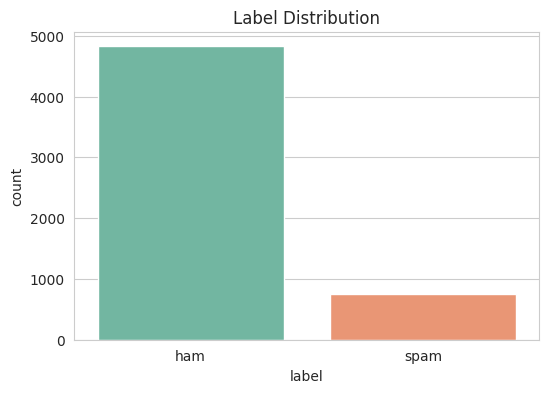

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

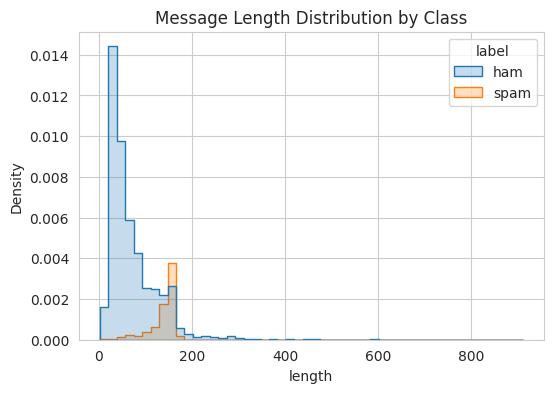

In [8]:

print("Class balance:")
display(df['label'].value_counts())

df['length'] = df['text'].str.len()
print(f"Average message length: {df['length'].mean():.1f} chars")

sns.countplot(x='label', data=df, palette="Set2")
plt.title("Label Distribution"); plt.show()

sns.histplot(df, x='length', hue='label', bins=50, element='step', stat='density')
plt.title("Message Length Distribution by Class"); plt.show()


## 🧼 4) Minimal Text Cleaning

In [9]:

def basic_clean(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " URL ", s)
    s = re.sub(r"\d+", " NUM ", s)
    s = re.sub(r"[(_)|\[\]{}<>~^`]", " ", s)  # remove some puncts
    s = re.sub(r"[_\-\=/\\]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['clean'] = df['text'].apply(basic_clean)
df[['text','clean','label']].head()


,text,clean,label
0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",ham
1,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in NUM a wkly comp to win fa cup fi...,spam
3,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...",ham


## ✂️ 5) Train / Test Split (stratified)

In [10]:

X_train, X_test, y_train, y_test = train_test_split(
    df['clean'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
print("Train/Test shapes:", X_train.shape, X_test.shape)
print("Train label counts:", y_train.value_counts().to_dict())
print("Test  label counts:", y_test.value_counts().to_dict())


Train/Test shapes: (4457,) (1115,)
Train label counts: {'ham': 3859, 'spam': 598}
Test  label counts: {'ham': 966, 'spam': 149}


## 🧮 6) TF‑IDF Vectorization + Models

In [11]:

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    strip_accents='unicode',
    sublinear_tf=True
)

def build_logreg():
    base = LogisticRegression(max_iter=2000, C=2.0, n_jobs=None)
    return Pipeline([('tfidf', tfidf), ('clf', base)])

def build_svm():
    base = LinearSVC(C=1.0)
    # For ROC/probabilities we wrap with calibration
    return Pipeline([('tfidf', tfidf), ('clf', CalibratedClassifierCV(base, cv=3))])

def build_nb():
    base = MultinomialNB(alpha=0.1)
    return Pipeline([('tfidf', tfidf), ('clf', base)])

models = {'LogReg': build_logreg(), 'LinearSVM': build_svm(), 'MultinomialNB': build_nb()}
list(models.keys())


['LogReg', 'LinearSVM', 'MultinomialNB']

## 🧪 7) Train, Evaluate, Compare

In [12]:

results = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    # Try to compute ROC-AUC when probabilities are available
    roc = None
    try:
        if hasattr(pipe.named_steps['clf'], "predict_proba"):
            proba = pipe.named_steps['clf'].predict_proba(pipe.named_steps['tfidf'].transform(X_test))[:,1]
        else:
            proba = pipe.predict_proba(X_test)[:,1]
        roc = roc_auc_score((y_test=='spam').astype(int), proba)
    except Exception:
        pass

    acc  = accuracy_score(y_test, pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, pred, average='binary', pos_label='spam')
    results.append([name, acc, pr, rc, f1, roc])

res_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','ROC-AUC'])
res_df.sort_values(by=['F1','ROC-AUC','Accuracy'], ascending=False)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
2,MultinomialNB,0.989238,0.992806,0.926174,0.958333,0.990444
1,LinearSVM,0.986547,0.940789,0.959732,0.950166,0.990548
0,LogReg,0.982063,0.951049,0.912752,0.931507,0.990145


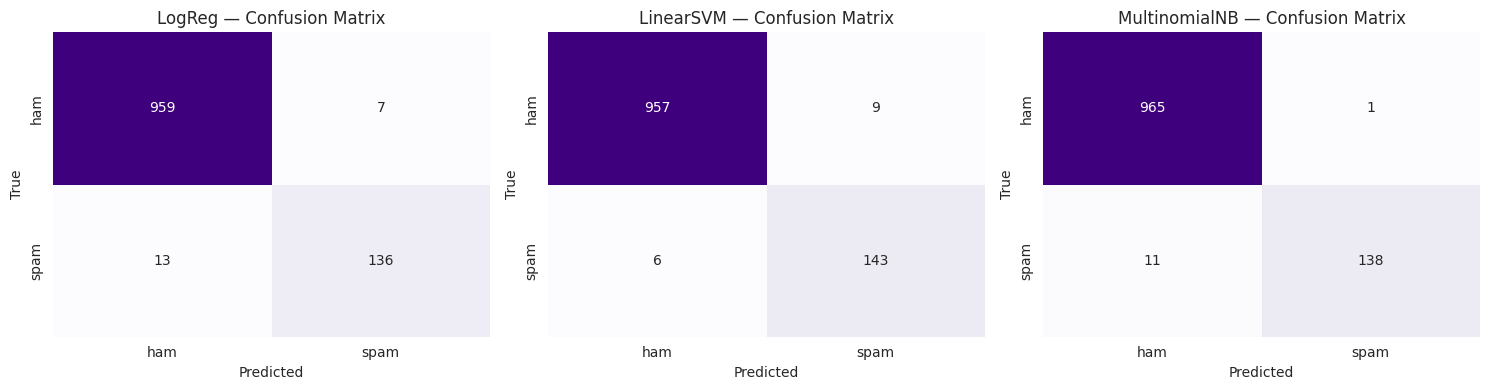

<Figure size 600x500 with 0 Axes>

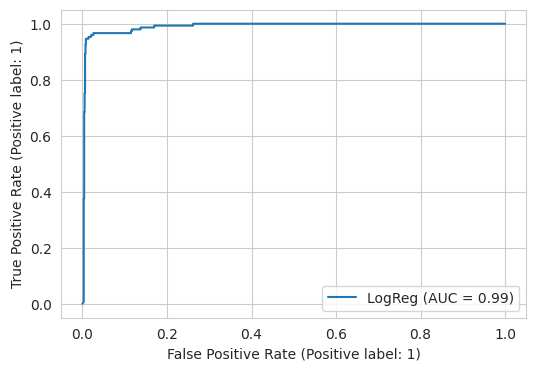

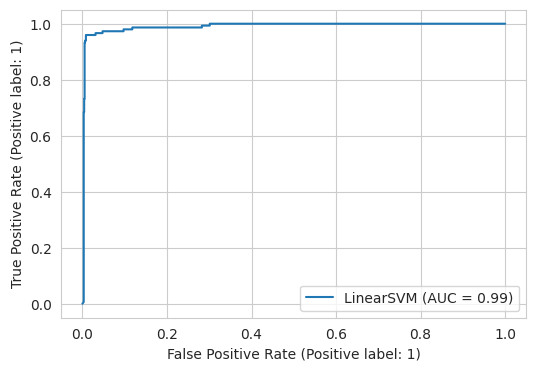

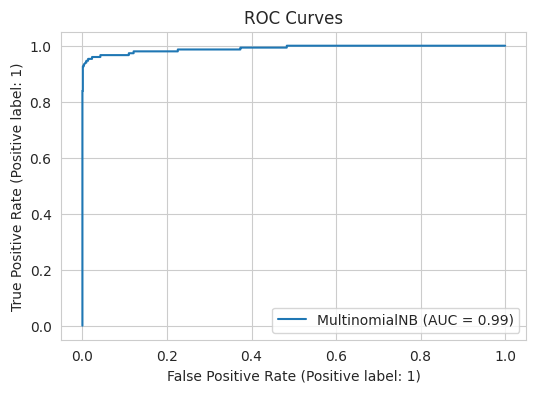

In [13]:

fig, axes = plt.subplots(1, len(models), figsize=(5*len(models),4))
if len(models) == 1:
    axes = [axes]

for ax, (name, pipe) in zip(axes, models.items()):
    pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, pred, labels=['ham','spam'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False, ax=ax,
                xticklabels=['ham','spam'], yticklabels=['ham','spam'])
    ax.set_title(f"{name} — Confusion Matrix")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

plt.tight_layout(); plt.show()

# ROC for models that support probas
plt.figure(figsize=(6,5))
for name, pipe in models.items():
    try:
        if hasattr(pipe.named_steps['clf'], "predict_proba"):
            proba = pipe.named_steps['clf'].predict_proba(pipe.named_steps['tfidf'].transform(X_test))[:,1]
        else:
            proba = pipe.predict_proba(X_test)[:,1]
        RocCurveDisplay.from_predictions((y_test=='spam').astype(int), proba, name=name)
    except Exception:
        pass
plt.title("ROC Curves")
plt.show()


## 🔍 8) Error Analysis + Top Tokens

In [14]:

best_name = res_df.sort_values(by=['F1','ROC-AUC','Accuracy'], ascending=False).iloc[0]['Model']
best_pipe = models[best_name]
print(f"Best model: {best_name}")

pred = best_pipe.predict(X_test)
err_idx = np.where(pred != y_test)[0][:10]
print("\nSample misclassifications:")
for i in err_idx:
    txt = X_test.iloc[i]
    print(f"[true={y_test.iloc[i]} | pred={pred[i]}]  {txt[:120]}{'...' if len(txt)>120 else ''}")

# Feature inspection for linear models (LogReg or LinearSVM via calibrated base)
if best_name in ('LogReg','LinearSVM'):
    vec = best_pipe.named_steps['tfidf']
    clf = best_pipe.named_steps['clf']
    # pull raw linear model inside calibrator for SVM
    if hasattr(clf, 'base_estimator_'):
        raw = clf.base_estimator_
        coefs = raw.coef_[0]
    else:
        try:
            coefs = clf.coef_[0]
        except Exception:
            coefs = None

    if coefs is not None:
        terms = np.array(vec.get_feature_names_out())
        top_spam = terms[np.argsort(coefs)[-20:][::-1]]
        top_ham  = terms[np.argsort(coefs)[:20]]
        print("\nTop spam‑indicative tokens:", ", ".join(top_spam))
        print("Top ham‑indicative tokens:", ", ".join(top_ham))


Best model: MultinomialNB

Sample misclassifications:
[true=spam | pred=ham]  freemsg hey there darling it's been NUM week's now and no word back! i'd like some fun you up for it still? tb ok! xxx s...
[true=spam | pred=ham]  ringtoneking NUM
[true=spam | pred=ham]  sorry i missed your call let's talk when you have the time. i'm on NUM
[true=spam | pred=ham]  latest news! police station toilet stolen, cops have nothing to go on!
[true=spam | pred=ham]  hi babe its jordan, how r u? im home from abroad and lonely, text me back if u wanna chat xxsp visionsms.com text stop t...
[true=spam | pred=ham]  for sale arsenal dartboard. good condition but no doubles or trebles!
[true=spam | pred=ham]  email alertfrom: jeri stewartsize: NUM kbsubject: low cost prescripiton drvgsto listen to email call NUM
[true=spam | pred=ham]  romcapspam everyone around should be responding well to your presence since you are so warm and outgoing. you are bringi...
[true=spam | pred=ham]  do you realize that in a

## 💾 9) Save Model

In [15]:

final_model = best_pipe
dump(final_model, "sms_spam_detector.joblib")
print("Saved → sms_spam_detector.joblib")


Saved → sms_spam_detector.joblib


## 🧪 10) Inference Helper

In [16]:

loaded = load("sms_spam_detector.joblib")

def predict_sms(texts):
    """texts: str or list[str] — returns DataFrame with label & spam_probability (if available)"""
    if isinstance(texts, str):
        texts = [texts]
    pred = loaded.predict(texts)
    out = {'text': texts, 'pred': pred}
    try:
        proba = loaded.predict_proba(texts)[:,1]
        out['spam_probability'] = proba
    except Exception:
        out['spam_probability'] = [None]*len(texts)
    return pd.DataFrame(out)

predict_sms([
    "WINNER! Claim your free prize now. Call 0800-123-456.",
    "Hey, are we still meeting at 6?"
])


,text,pred,spam_probability
0,WINNER! Claim your free prize now. Call 0800-1...,spam,0.999637
1,"Hey, are we still meeting at 6?",ham,0.000912
